In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# Read Parquet File
df_name = 'ds1_train'
df = pd.read_parquet(f'../data/split/resplit/{df_name}.parquet')

df = df.replace([np.inf], 1e6)
df = df.replace([-np.inf], -1e6)

In [43]:
categorical_features = ['std_txn_type', 'std_txn_method', 'prev_std_txn_type', 'prev_std_txn_method']

onehot = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

encoded_cat = []
encoded_names = []

encoded_features = onehot.fit_transform(df[categorical_features])
encoded_feature_names = onehot.get_feature_names_out(categorical_features)

df_encoded = pd.concat([df.drop(columns=categorical_features), pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)], axis=1)

df_encoded['prev_USD_amount'] = df_encoded['prev_USD_amount'].fillna(0) 
df_encoded['prev_age_delta'] = df_encoded['prev_age_delta'].fillna(0)

In [44]:
non_object = df_encoded.select_dtypes(exclude=['object', 'datetime64[ns]']).columns
non_object[1:]

Index(['is_credit', 'USD_amount', 'txn_time_hr', 'txn_time_mm', 'txn_age_days',
       'prev_USD_amount', 'prev_age_delta', 'volume_7d_sum',
       'velocity_7d_count', 'stat_7d_median', 'stat_7d_mad',
       'under_threshold_7d_count', 'under_threshold_7d_sum', 'volume_14d_sum',
       'velocity_14d_count', 'stat_14d_median', 'stat_14d_mad',
       'under_threshold_14d_count', 'under_threshold_14d_sum',
       'volume_30d_sum', 'velocity_30d_count', 'stat_30d_median',
       'stat_30d_mad', 'under_threshold_30d_count', 'under_threshold_30d_sum',
       'is_crossborder', 'stat_7d_modzscr', 'stat_14d_modzscr',
       'stat_30d_modzscr', 'party_entity_btw', 'party_entity_deg',
       'party_account_btw', 'party_account_deg', 'cparty_l1_btw',
       'cparty_l1_deg', 'cparty_l2_btw', 'cparty_l2_deg', 'cparty_is_cash',
       'cparty_is_standalone', 'cparty_is_account', 'std_txn_type_PAYMENT',
       'std_txn_type_TRANSFER', 'std_txn_type_WITHDRAWAL',
       'std_txn_method_ELECTRONIC', 'pr

In [53]:
mi_scores = mutual_info_classif(df_encoded[non_object[1:]], df_encoded['Label'], n_jobs=5)

In [67]:
mi_df = pd.DataFrame({
        'Feature': df_encoded[non_object[1:]].columns,
        'MI_Score': mi_scores
    })

for ohe_ft in categorical_features:
    filtered = mi_df[mi_df['Feature'].str.startswith(ohe_ft)]
    mean_mi_score = filtered['MI_Score'].mean()

    mi_df = mi_df[~mi_df['Feature'].str.startswith(ohe_ft)]

    new_row = pd.DataFrame({'Feature': [ohe_ft], 'MI_Score': [mean_mi_score]})
    mi_df = pd.concat([mi_df, new_row], ignore_index=True)

mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

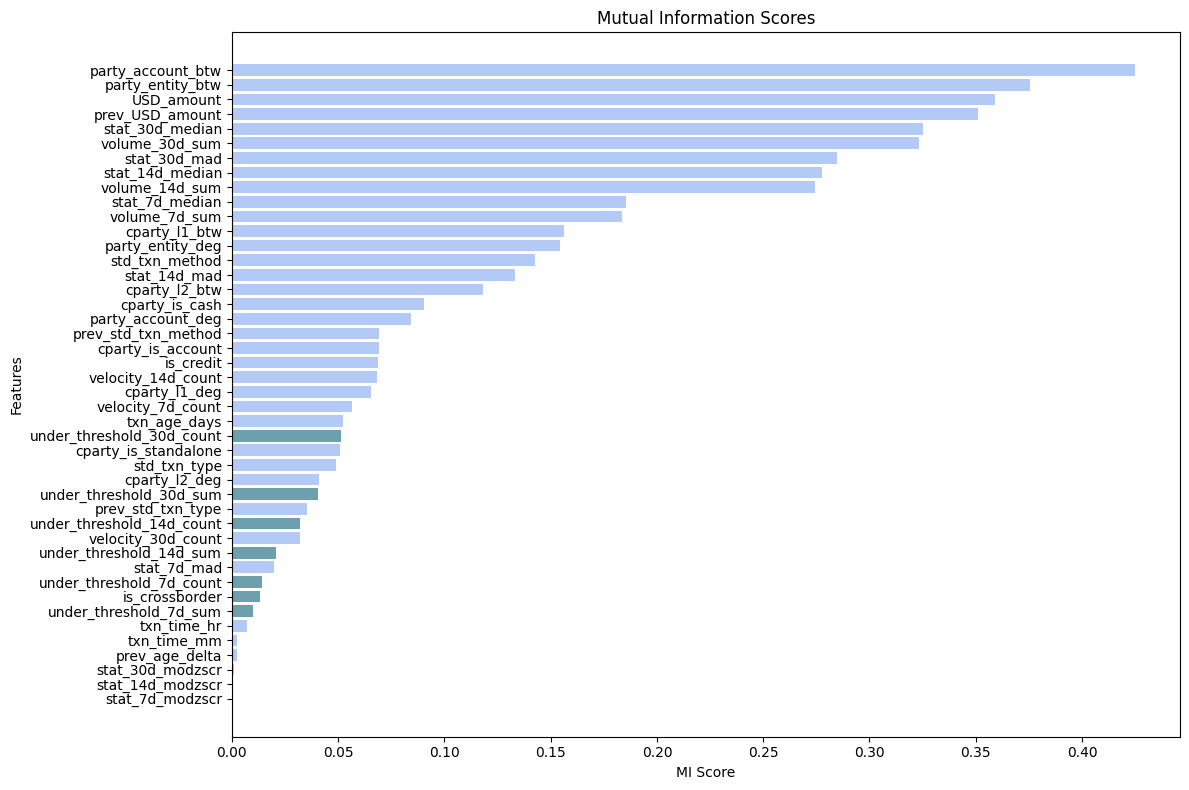

In [76]:

def plot_mutual_info(mi_df, df_name):
    # Sort values for better visualization
    mi_df_sorted = mi_df.sort_values('MI_Score', ascending=True)
    
    # Create figure with larger size
    plt.figure(figsize=(12, 8))

    typo_prefix = ('is_crossborder', 'under_threshold')

    colors = ['#6BA0AC' if any([typo in feature for typo in typo_prefix]) else '#B2CAF5' for feature in mi_df_sorted['Feature']]
    # Horizontal bar plot
    plt.barh(mi_df_sorted['Feature'], mi_df_sorted['MI_Score'], color=colors)
    plt.title('Mutual Information Scores')
    plt.xlabel('MI Score')
    plt.ylabel('Features')
    
    # Rotate feature labels if needed
    plt.tight_layout()
    plt.savefig(f'../data/feature_selection/{df_name}_mutual_info.png', dpi=300, transparent=True),
    plt.show()

plot_mutual_info(mi_df)

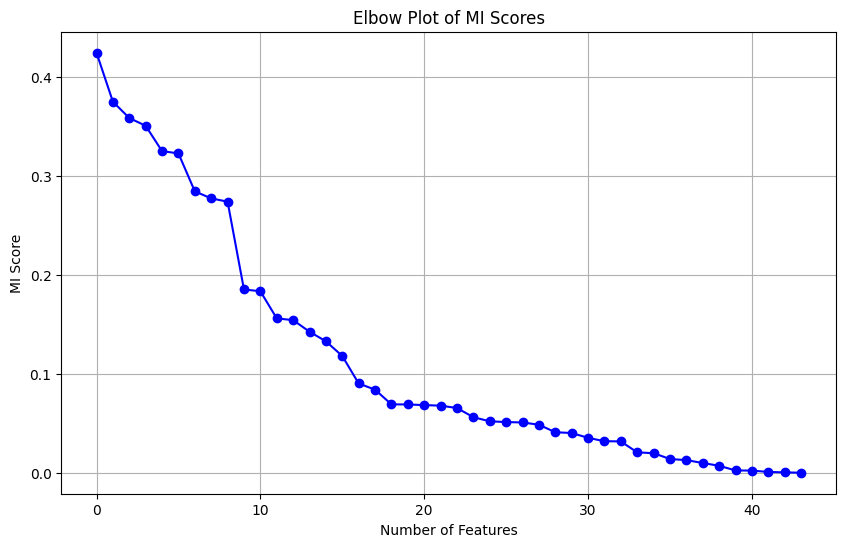

In [70]:
def plot_mi_elbow(mi_df):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(mi_df)), mi_df['MI_Score'], 'bo-')
    plt.xlabel('Number of Features')
    plt.ylabel('MI Score')
    plt.title('Elbow Plot of MI Scores')
    plt.grid(True)
    plt.savefig(f'../data/feature_selection/{df_name}_mi_elbow.png', dpi=300, transparent=True)
    plt.show()

plot_mi_elbow(mi_df)

In [87]:
import numpy as np
from sklearn.metrics import mutual_info_score
import pandas as pd

def detect_collinearity_with_mi(df, threshold=0.9):
    n_features = df.shape[1]
    mi_matrix = np.zeros((n_features, n_features))
    
    for i in range(n_features):
        for j in range(i+1, n_features):
            mi = mutual_info_score(df.iloc[:,i], df.iloc[:,j])
            mi_matrix[i,j] = mi
            mi_matrix[j,i] = mi
    
    def normalize_mi_by_entropy(mi_matrix):
        """
        Normalize MI matrix by dividing by max entropy
        """
        max_entropy = np.log2(len(mi_matrix))  # If using log2
        normalized_matrix = mi_matrix / max_entropy
        return normalized_matrix

    mi_matrix = normalize_mi_by_entropy(mi_matrix)
    
    # Find highly collinear pairs
    collinear_pairs = []
    for i in range(n_features):
        for j in range(i+1, n_features):
            if mi_matrix[i,j] > threshold:
                collinear_pairs.append((df.columns[i], df.columns[j], mi_matrix[i,j]))
                
    return mi_matrix, collinear_pairs

In [78]:
mi_matrix, collinear_pairs = detect_collinearity_with_mi(df_encoded[non_object[1:]], threshold=1.5)

c:\Users\al2-esplana\.conda\envs\mscds_dsrtn\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\al2-esplana\.conda\envs\mscds_dsrtn\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\al2-esplana\.conda\envs\mscds_dsrtn\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
c:\Users\al2-esplana\.conda\envs\mscds_dsrtn\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label,

<module 'matplotlib.pyplot' from 'c:\\Users\\al2-esplana\\.conda\\envs\\mscds_dsrtn\\Lib\\site-packages\\matplotlib\\pyplot.py'>

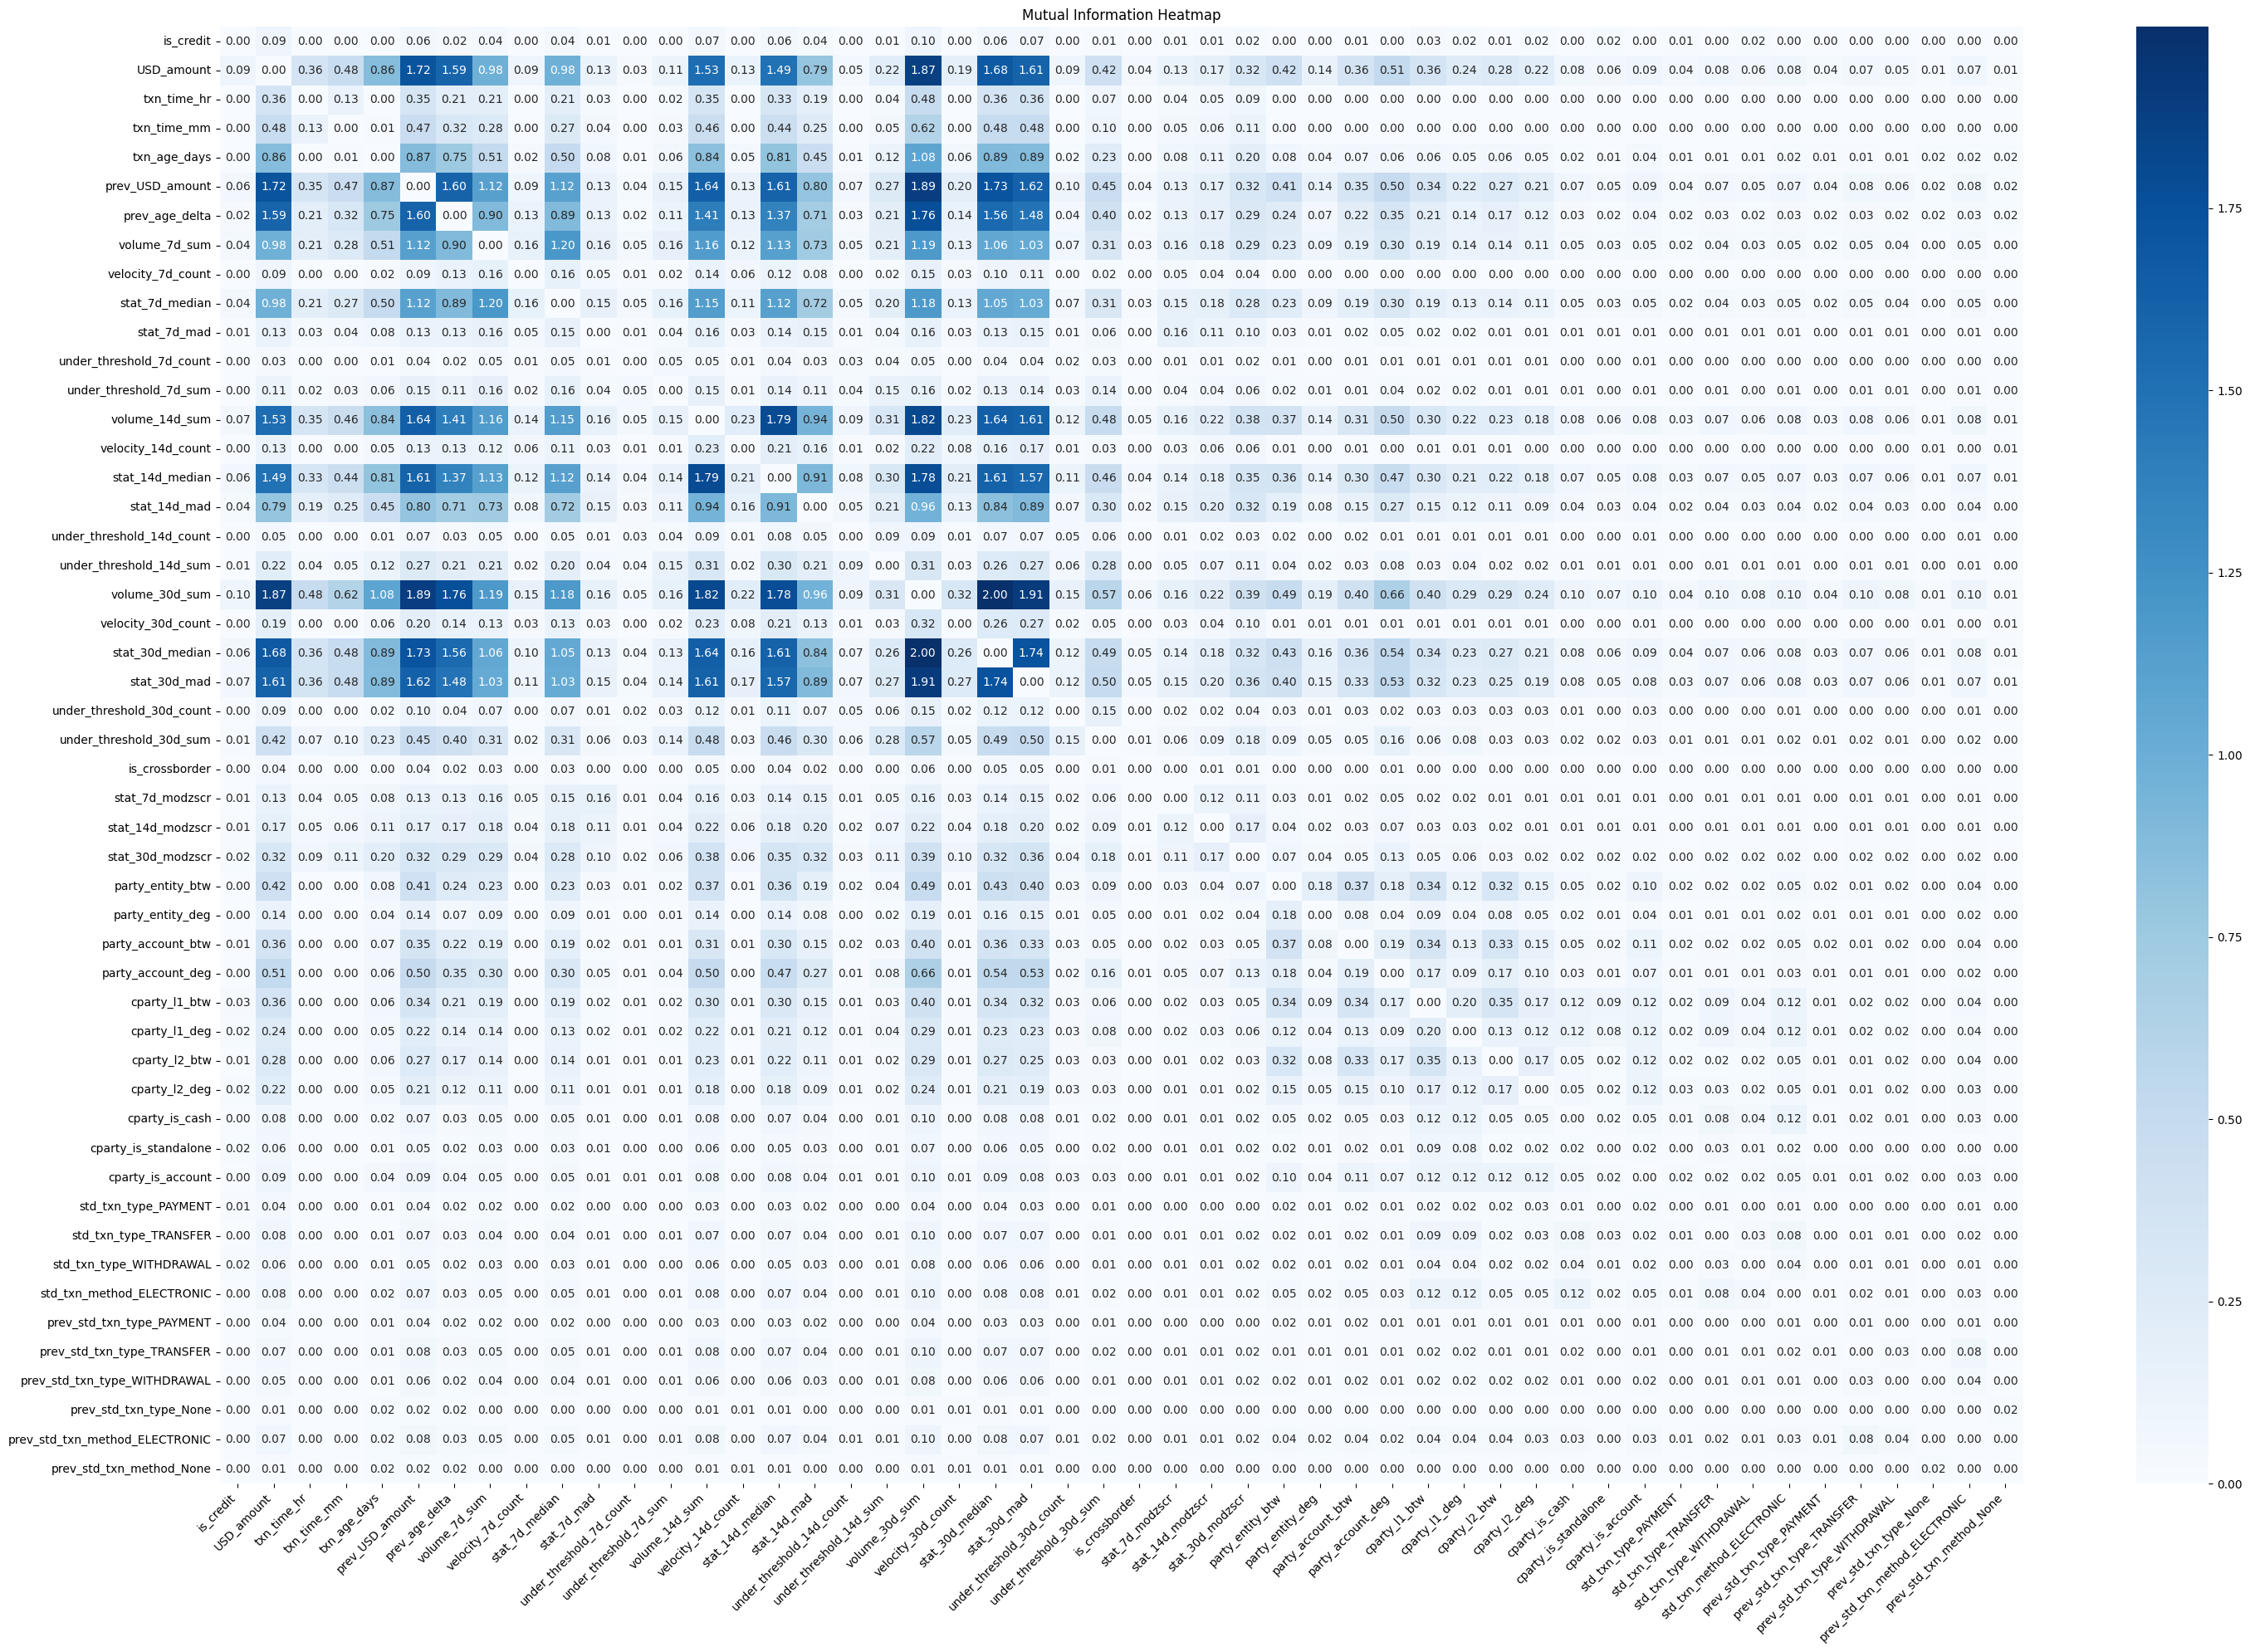

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mi_heatmap(mi_matrix, feature_names=None):
    """
    Plot MI matrix heatmap
    
    Parameters:
    mi_matrix: numpy array of mutual information scores
    feature_names: list of feature names (optional)
    """
    plt.figure(figsize=(30, 20))
    
    # If feature names not provided, use indices
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(len(mi_matrix))]
    
    sns.heatmap(
        pd.DataFrame(mi_matrix, index=feature_names, columns=feature_names),
        annot=True,  # Show numbers
        cmap='Blues',
        vmin=0,
        vmax=np.max(mi_matrix),  # Or set to 1 if normalized
        fmt='.2f'
    )
    
    plt.title('Mutual Information Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'../data/feature_selection/{df_name}_mi_heatmap.png', dpi=150, transparent=True)
    
    return plt

plot_mi_heatmap(mi_matrix, feature_names=df_encoded[non_object[1:]].columns)

In [88]:
pd.DataFrame(mi_matrix[1], columns=['feature1', 'feature2', 'mi_score']).to_csv(f'../data/feature_selection/{df_name}_high_col.csv', index=False)

[('USD_amount', 'txn_time_hr', 2.0055682951207565),
 ('USD_amount', 'txn_time_mm', 2.6851611315435058),
 ('USD_amount', 'txn_age_days', 4.862980673712257),
 ('USD_amount', 'prev_USD_amount', 9.719478112222811),
 ('USD_amount', 'prev_age_delta', 8.995415360872203),
 ('USD_amount', 'volume_7d_sum', 5.546384956664436),
 ('USD_amount', 'stat_7d_median', 5.518649029139384),
 ('USD_amount', 'volume_14d_sum', 8.627461676341712),
 ('USD_amount', 'stat_14d_median', 8.424815207033623),
 ('USD_amount', 'stat_14d_mad', 4.470885604480768),
 ('USD_amount', 'under_threshold_14d_sum', 1.2562367443680866),
 ('USD_amount', 'volume_30d_sum', 10.58070076462036),
 ('USD_amount', 'velocity_30d_count', 1.0827501726882443),
 ('USD_amount', 'stat_30d_median', 9.47643518786478),
 ('USD_amount', 'stat_30d_mad', 9.060394101754099),
 ('USD_amount', 'under_threshold_30d_sum', 2.37226295150049),
 ('USD_amount', 'stat_14d_modzscr', 0.9837361049596122),
 ('USD_amount', 'stat_30d_modzscr', 1.786487607612227),
 ('USD_am

: 